# Neural Networks and Deep Learning - Homework 1: Supervised Learning
## Classification Task
## Rosset Lorenzo, mat. 2021859

In [1]:
!git clone https://github.com/rossetl/NNDL.git
%cd NNDL/Homework\ 1

Cloning into 'NNDL'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 49 (delta 7), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (49/49), done.
/content/NNDL/Homework 1


In [2]:
from re import I
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from torch.utils.data.dataset import Subset

In [24]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.), (1.))]) # try to change this

train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=transform)

In [25]:
BATCHSIZE = 10
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 10
print(f'Training device:', DEVICE)

Training device: cuda


In [26]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=1)

In [27]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: classifier_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.0, std=1.0)
           )

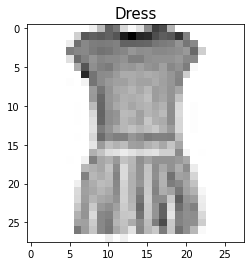

In [39]:
classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def imshow(img, title):
    npimg = img.numpy()[0]
    plt.imshow(npimg, cmap='Greys')
    plt.title(title, size=15)
    plt.show()

idx = 3
imshow(train_dataset[idx][0], classes[train_dataset[idx][1]])

## Simple Convolutional Network

In [59]:
class Conv_net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool=nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(12*4*4, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [60]:
conv_net = Conv_net().to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_net.parameters(), lr=1e-3)

In [61]:
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    train_loss = []
    model.train()
    for sample_batched in dataloader:
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        out = model(x_batch)
        loss = loss_fn(out, label_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
    return np.mean(train_loss)

def val_epoch(model, device, dataloader, loss_fn):
    val_loss = []
    model.eval()
    with torch.no_grad():
        for sample_batched in dataloader:
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)
            out = model(x_batch)
            loss = loss_fn(out, label_batch)
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
    return np.mean(val_loss)

In [62]:
num_epochs = 5
train_loss_log = []
test_loss_log = []
for epoch in range(num_epochs):
    train_loss = train_epoch(conv_net, DEVICE, train_dataloader, loss_fn, optimizer)
    train_loss_log.append(train_loss)

    test_loss = val_epoch(conv_net, DEVICE, test_dataloader, loss_fn)
    test_loss_log.append(test_loss)

    print('Epoch {:}/{:}, avg train loss: {:.3f}, avg test loss: {:.3f}'.format(epoch + 1, num_epochs, train_loss, test_loss))

Epoch 1/5, avg train loss: 0.562, avg test loss: 0.414
Epoch 2/5, avg train loss: 0.367, avg test loss: 0.362
Epoch 3/5, avg train loss: 0.323, avg test loss: 0.340
Epoch 4/5, avg train loss: 0.295, avg test loss: 0.332
Epoch 5/5, avg train loss: 0.278, avg test loss: 0.322
